<a href="https://colab.research.google.com/github/dcatrib/tesePython/blob/main/Testes_Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyMuPDF requests selenium chromedriver-autoinstaller pandas nltk gensim numpy skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 961.6 kB/s eta 0:00:00


In [ ]:
import requests
import os
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from google.colab import files
import numpy as np
from gensim.models import KeyedVectors, Word2Vec
import gensim
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

In [10]:
# Faça o upload do arquivo
uploaded = files.upload()

# Carregando o arquivo Excel corretamente
df_final = pd.read_excel('corpus.xlsx')  # Corrigido para corpus.xlsx


# Extraindo a quarta coluna como corpus (fazendo limpeza de valores não-texto)
corpus = df_final.iloc[:, 11].dropna().tolist()  # Remove valores NaN

corpus = [text for text in corpus if isinstance(text, str) and text.strip() != ""]

# Pré-processamento do texto (divisão em palavras)
# Aqui estamos usando um simples split, mas você pode querer fazer mais pré-processamento
corpus_tokenized = [text.split() for text in corpus]

# Word2Vec (cbow)
print("Treinando Word2Vec...")
word2vec_model = gensim.models.Word2Vec(corpus_tokenized, vector_size=300, window=5, min_count=100, workers=4)
print(df_final.head(20))

Saving corpus.xlsx to corpus (1).xlsx
Treinando Word2Vec...
                                                 Link  \
0   https://www.bcb.gov.br/en/publications/copommi...   
1   https://www.bcb.gov.br/en/publications/copommi...   
2   https://www.bcb.gov.br/en/publications/copommi...   
3   https://www.bcb.gov.br/en/publications/copommi...   
4   https://www.bcb.gov.br/en/publications/copommi...   
5   https://www.bcb.gov.br/en/publications/copommi...   
6   https://www.bcb.gov.br/en/publications/copommi...   
7   https://www.bcb.gov.br/en/publications/copommi...   
8   https://www.bcb.gov.br/en/publications/copommi...   
9   https://www.bcb.gov.br/en/publications/copommi...   
10  https://www.bcb.gov.br/en/publications/copommi...   
11  https://www.bcb.gov.br/en/publications/copommi...   
12  https://www.bcb.gov.br/en/publications/copommi...   
13  https://www.bcb.gov.br/en/publications/copommi...   
14  https://www.bcb.gov.br/en/publications/copommi...   
15  https://www.bcb.gov.br/e

In [11]:
#Agrupando pelo trimestre
cols_to_join = [col for col in df_final.columns if col not in ['Valor', 'Valor2', 'trimestre']]
agg_dict = {'Valor': 'first', 'Valor2': 'first'}
for col in cols_to_join:
    agg_dict[col] = lambda x: ' '.join(x.astype(str))

df_agrupado = df_final.groupby('trimestre').agg(agg_dict)
df_agrupado = df_agrupado.reset_index()

print(df_agrupado)

   trimestre  Valor     Valor2  \
0    2003-2T    3.2   418987.0   
1    2003-3T    2.3   439350.0   
2    2003-4T    1.1   462372.0   
3    2004-1T    1.4   444783.0   
4    2004-2T    2.8   481795.0   
..       ...    ...        ...   
82   2023-4T    2.9  2831340.0   
83   2024-1T    2.5  2713917.0   
84   2024-2T    2.5  2887650.0   
85   2024-3T    NaN        NaN   
86   2024-4T    NaN        NaN   

                                                 Link  \
0   https://www.bcb.gov.br/en/publications/copommi...   
1   https://www.bcb.gov.br/en/publications/copommi...   
2   https://www.bcb.gov.br/en/publications/copommi...   
3   https://www.bcb.gov.br/en/publications/copommi...   
4   https://www.bcb.gov.br/en/publications/copommi...   
..                                                ...   
82  https://www.bcb.gov.br/en/publications/copommi...   
83  https://www.bcb.gov.br/en/publications/copommi...   
84  https://www.bcb.gov.br/en/publications/copommi...   
85  https://www.bcb.g

['recent evolution inflation measures inflation registered smallest monthly increases development pronounced wholesale price indices mainly due effects recent exchange rate appreciation seasonal contribution agricultural goods prices decline consumer price inflation smaller reflecting modest deceleration market price inflation increases regulated prices ipca increased comparison previous accumulating months months igpdi increased compared ipadi rose comparison previous increase igpdi ipadi fell increased eleven consecutive months totaling respectively deceleration ipca inflation resulted exclusively evolution market prices increased compared among market prices main contribution slowdown came food prices thanks particularly normalization supply perishable foods reflecting favorable weather conditions consequence prices perishable food increased comparison among tradable goods apart food items smaller increase ipca due behavior prices medicines household goods cleaning personal hygiene 

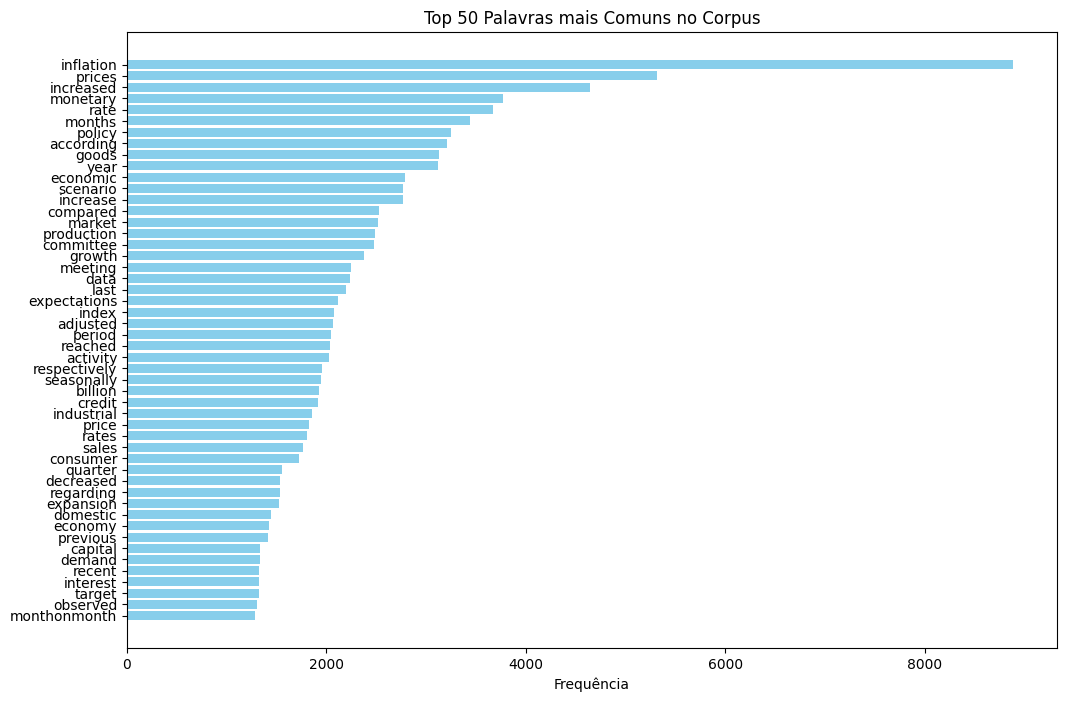


Estatísticas adicionais:
Total de palavras: 428998
Total de palavras únicas: 6234
Comprimento médio das palavras: 7.52 caracteres


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
print(corpus[:3])  # Exibe as 3 primeiras amostras processadas

# Flatten the list of tokenized words (corpus_tokenized)
flat_corpus = [word for sublist in corpus_tokenized for word in sublist]

# Contar a frequência de palavras
word_freq = Counter(flat_corpus)

# Obter as 20 palavras mais comuns e suas frequências
top_50_words = word_freq.most_common(50)

# Exibindo as 20 palavras mais comuns
print("As 50 palavras mais comuns:")
for word, freq in top_50_words:
    print(f"{word}: {freq}")

# Visualizar as 20 palavras mais comuns com um gráfico
words, freqs = zip(*top_50_words)
plt.figure(figsize=(12, 8))
plt.barh(words, freqs, color='skyblue')
plt.xlabel('Frequência')
plt.title('Top 50 Palavras mais Comuns no Corpus')
plt.gca().invert_yaxis()  # Para as palavras mais frequentes ficarem no topo
plt.show()

# Outras estatísticas
total_palavras = len(flat_corpus)
total_palavras_unicas = len(word_freq)
comprimento_medio_palavra = np.mean([len(word) for word in flat_corpus])

print(f"\nEstatísticas adicionais:")
print(f"Total de palavras: {total_palavras}")
print(f"Total de palavras únicas: {total_palavras_unicas}")
print(f"Comprimento médio das palavras: {comprimento_medio_palavra:.2f} caracteres")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['recent', 'evolution', 'inflation', 'measures', 'inflation', 'registered', 'smallest', 'monthly', 'increases', 'development', 'pronounced', 'wholesale', 'price', 'indices', 'mainly', 'due', 'effects', 'recent', 'exchange', 'rate', 'appreciation', 'seasonal', 'contribution', 'agricultural', 'goods', 'prices', 'decline', 'consumer', 'price', 'inflation', 'smaller', 'reflecting', 'modest', 'deceleration', 'market', 'price', 'inflation', 'increases', 'regulated', 'prices', 'ipca', 'increased', 'comparison', 'previous', 'accumulating', 'months', 'months', 'igpdi', 'increased', 'compared']


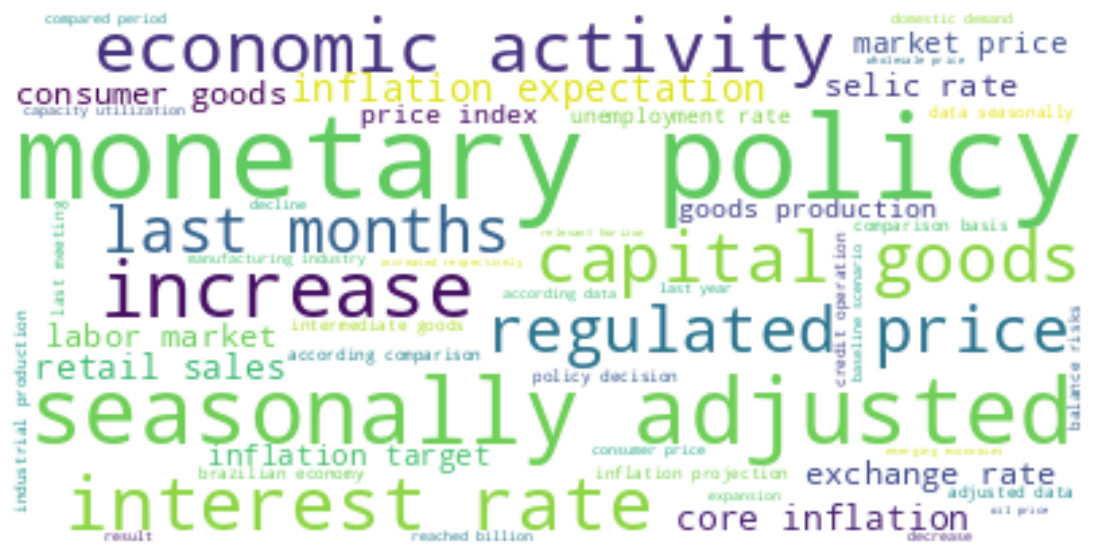

In [ ]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Download the 'punkt' resource for tokenization
nltk.download('punkt_tab')

text = " ".join(corpus)

# Tokenize the text into individual words using NLTK
tokens = word_tokenize(text)
print(tokens[:50])  # Print the first 50 tokens

# Join the tokens back into a string
text_for_wordcloud = " ".join(tokens)

# Generate the word cloud with the tokenized text
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text_for_wordcloud) #com frases
#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text_for_wordcloud)

plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the 'vader_lexicon' resource
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# Convert the 'Texto Processado2' column to strings, handling NaN values
df_agrupado['Texto Processado2'] = df_agrupado['Texto Processado2'].astype(str)

df_agrupado['polarity'] = df_agrupado['Texto Processado2'].apply(lambda x: analyzer.polarity_scores(x))


# Change data structure
df_agrupado = pd.concat(
    [df_agrupado.drop(['polarity'], axis=1),
     df_agrupado['polarity'].apply(pd.Series)], axis=1)
df_agrupado.head(4)
# Create new variable with sentiment "neutral," "positive" and "negative"
df_agrupado['sentiment'] = df_agrupado['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df_agrupado.head(4)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,trimestre,Valor,Valor2,Link,Texto,Link de Download,Texto do PDF,Texto Processado,Ano_Mes,A,B,C,D,Footnotes,Texto Processado2,neg,neu,pos,compound,sentiment
0,2003-2T,3.2,418987.0,https://www.bcb.gov.br/en/publications/copommi...,84th Copom minutes - May 2003 85th Copom minut...,https://www.bcb.gov.br/content/copom/copomminu...,Minutes of the 84th Meeting of the Monetary Po...,recent evolution inflation measures inflation ...,2003-05 2003-06,nan nan,nan nan,nan nan,nan nan,nan nan,recent evolution inflation measures inflation ...,0.063,0.759,0.178,0.9999,positive
1,2003-3T,2.3,439350.0,https://www.bcb.gov.br/en/publications/copommi...,86th Copom minutes - July 2003 87th Copom minu...,https://www.bcb.gov.br/content/copom/copomminu...,1 Minutes of the 86th Meeting of the Monetary ...,recent evolution inflation inflation continued...,2003-07 2003-08 2003-09,nan nan nan,nan nan nan,nan nan nan,nan nan nan,nan nan nan,recent evolution inflation inflation continued...,0.059,0.770,0.171,1.0000,positive
2,2003-4T,1.1,462372.0,https://www.bcb.gov.br/en/publications/copommi...,89th Copom minutes - October 2003 90th Copom m...,https://www.bcb.gov.br/content/copom/copomminu...,1 Minutes of the 89th Meeting of the Monetary ...,recent evolution inflation main price indices ...,2003-10 2003-11 2003-12,nan nan nan,nan nan nan,nan nan nan,nan nan nan,nan nan nan,recent evolution inflation main price indices ...,0.040,0.755,0.205,1.0000,positive
3,2004-1T,1.4,444783.0,https://www.bcb.gov.br/en/publications/copommi...,92nd Copom minutes - January 2004 93rd Copom m...,https://www.bcb.gov.br/content/copom/copomminu...,Minutes of the 92nd Meeting of the Monetary Po...,recent evolution inflation broad consumer pric...,2004-01 2004-02 2004-03,nan nan nan,nan nan nan,nan nan nan,nan nan nan,nan nan nan,recent evolution inflation broad consumer pric...,0.050,0.766,0.184,1.0000,positive


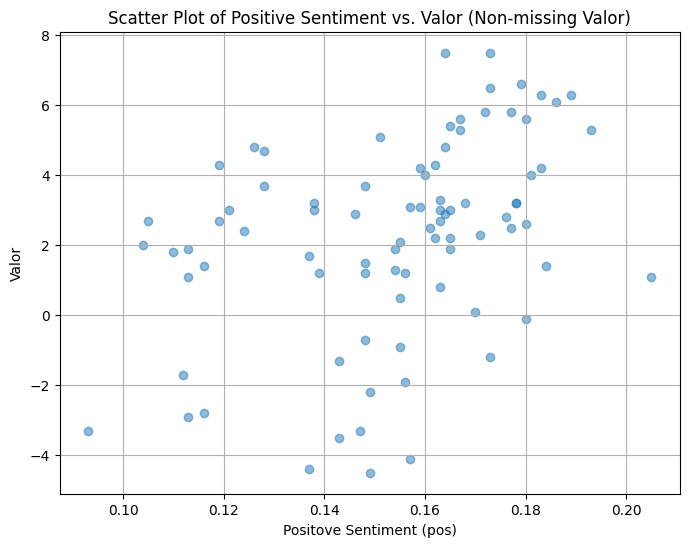

In [15]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows where 'Valor' is not missing
filtered_df = df_agrupado

# Extract the 'neg' and 'Valor' columns from the filtered DataFrame
pos_values = filtered_df['pos']
valor_values = filtered_df['Valor']

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(pos_values, valor_values, alpha=0.5)  # alpha controls point transparency
plt.xlabel("Positove Sentiment (pos)")
plt.ylabel("Valor")
plt.title("Scatter Plot of Positive Sentiment vs. Valor (Non-missing Valor)")
plt.grid(True)  # Add a grid for better visualization
plt.show()

In [18]:
# Função para obter o vetor médio
def get_average_vector(text):
    if isinstance(text, str):  # Verifica se o texto é uma string
        words = text.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
    return np.zeros(word2vec_model.vector_size)  # Retorna vetor zero se não houver palavras válidas ou se o texto não for string

# Criar a nova coluna 'Texto Processado'
df_agrupado['Vetor Médio'] = df_agrupado['Texto Processado2'].apply(get_average_vector)

AR2 MSE: 1.0081194337506914
LinearRegression MSE: 9.352818932597255
   trimestre  Valor_Atual  AR2_Previsto  LinearRegression_Previsto
40   2013-2T          2.9      2.286781                   3.925591
41   2013-3T          3.0      3.239427                   3.828735
42   2013-4T          3.0      2.896487                   2.589886
43   2014-1T          3.2      2.817408                   1.845017
44   2014-2T          2.1      3.148033                   4.942971
45   2014-3T          1.2      1.190262                   3.564655
46   2014-4T          0.5      0.479986                   3.113963
47   2015-1T         -0.7     -0.031894                   2.754499
48   2015-2T         -1.3     -1.520457                  -1.621655
49   2015-3T         -2.2     -1.651033                  -1.654894
50   2015-4T         -3.5     -2.726776                  -3.049994
51   2016-1T         -4.4     -4.269162                  -2.644823
52   2016-2T         -4.5     -4.806324                  -2.6

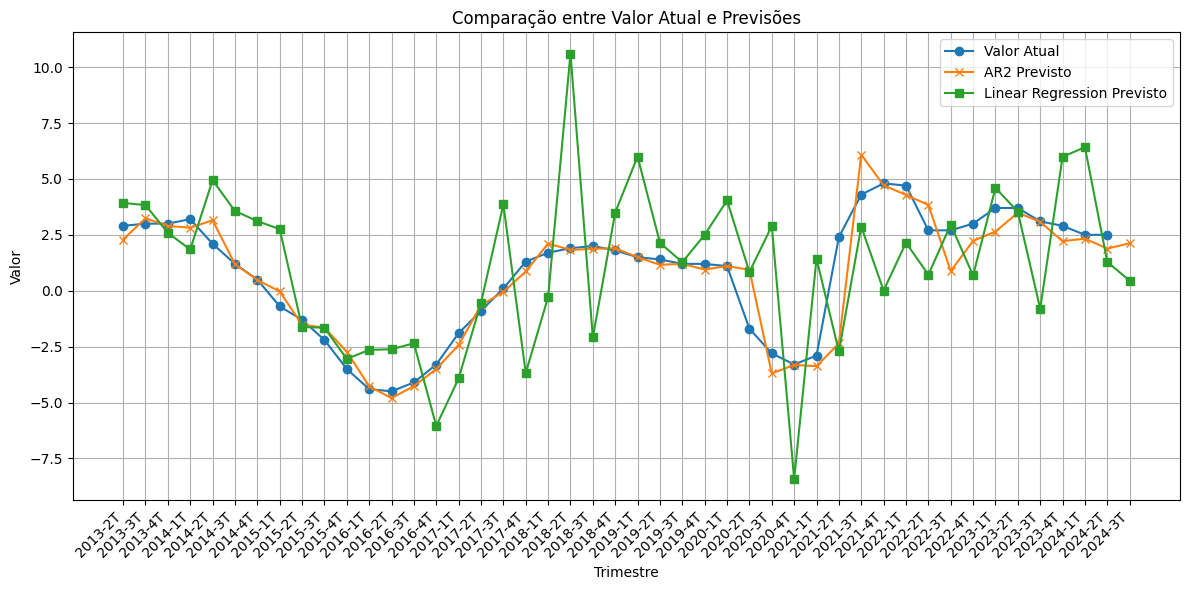

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Assuming df_agrupado is your DataFrame with 'trimestre', 'Valor', and 'Vetor Médio' columns

window_size = 40
forecasts = {'AR2': [], 'LinearRegression': []}

for i in range(window_size, len(df_agrupado) - 1):
    train_data = df_agrupado.iloc[i - window_size:i]
    test_data = df_agrupado.iloc[i:i + 1]
    y_train, y_test = train_data['Valor'], test_data['Valor']
    X_train = np.array(train_data['Vetor Médio'].tolist()).reshape(len(train_data), -1)
    X_test = np.array(test_data['Vetor Médio'].tolist()).reshape(len(test_data), -1)

    try:
        forecasts['AR2'].extend(AutoReg(y_train, lags=2, trend='n', seasonal=False).fit().predict(start=len(y_train), end=len(y_train)))
    except ValueError:
        forecasts['AR2'].extend([np.nan])

    forecasts['LinearRegression'].extend(LinearRegression().fit(X_train, y_train).predict(X_test))

for model_name, predicted_values in forecasts.items():
    diff = len(df_agrupado['Valor'][window_size:]) - len(predicted_values)
    actual_values = df_agrupado['Valor'][window_size: len(df_agrupado['Valor']) - diff].to_numpy()
    valid_indices = ~np.isnan(predicted_values) & ~np.isnan(actual_values)  # Filter for both
    predicted_values = np.array(predicted_values)
    mse = mean_squared_error(actual_values[valid_indices], predicted_values[valid_indices])
    print(f'{model_name} MSE: {mse}')

# Calculate the difference in length
diff = len(df_agrupado['Valor'][window_size:]) - len(forecasts['AR2'])  # Or forecasts['LinearRegression']

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'trimestre': df_agrupado['trimestre'][window_size:len(df_agrupado['trimestre']) - diff],  # Adjusted slicing
    'Valor_Atual': df_agrupado['Valor'][window_size:len(df_agrupado['Valor']) - diff],  # Adjusted slicing
    'AR2_Previsto': forecasts['AR2'],
    'LinearRegression_Previsto': forecasts['LinearRegression']
})

print(results_df)

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(results_df['trimestre'], results_df['Valor_Atual'], label='Valor Atual', marker='o')
plt.plot(results_df['trimestre'], results_df['AR2_Previsto'], label='AR2 Previsto', marker='x')
plt.plot(results_df['trimestre'], results_df['LinearRegression_Previsto'], label='Linear Regression Previsto', marker='s')

# Customize the plot
plt.xlabel('Trimestre')
plt.ylabel('Valor')
plt.title('Comparação entre Valor Atual e Previsões')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

LinearRegression MSE: 3.8744572041684147
Lasso MSE: 7.062009549492779
Ridge MSE: 5.460988696383849
AR2 MSE: 1.0932060348156427
RandomForest MSE: 4.264439585714287
    Actual  LinearRegression     Lasso     Ridge       AR2  RandomForest
15     4.2          4.641936  3.513334  3.753324  4.339493         3.821
16     5.3          4.801605  3.580000  3.832653  4.244213         4.209
17     5.6          5.605314  3.780000  4.084800  6.008685         4.391
18     6.1          5.523072  4.080000  4.379265  5.676163         4.812
19     6.3          6.299687  4.393333  4.738683  6.292269         5.285
..     ...               ...       ...       ...       ...           ...
80     3.7          4.361368  1.406667  2.098413  3.160432         2.780
81     3.1          2.785927  1.573334  2.428669  2.843325         1.240
82     2.9          3.170300  1.700000  2.016643  2.174841         2.095
83     2.5          1.220010  1.820000  2.166839  2.269464         1.550
84     2.5          4.011275  2.10

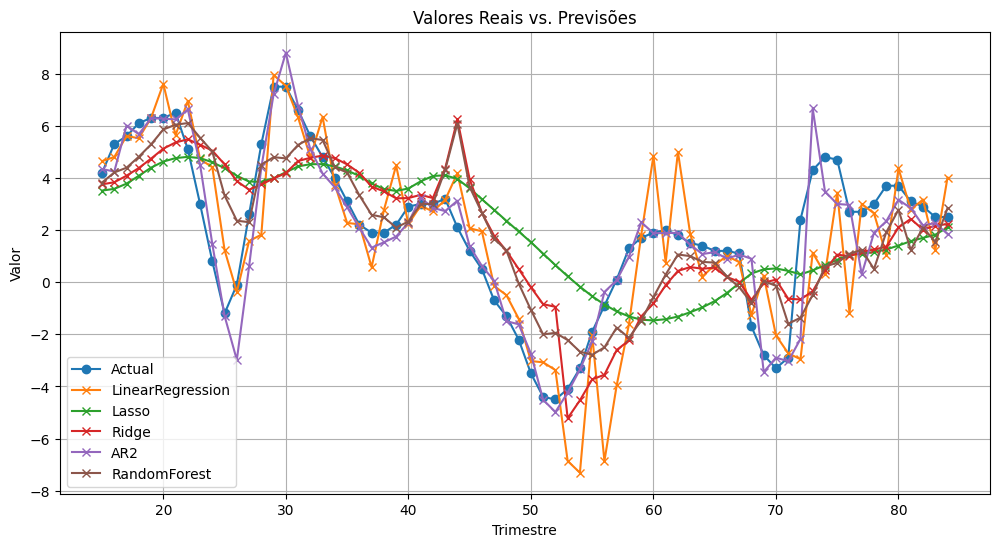

In [72]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Descartar as observações onde a coluna 'Valor' é missing (NaN)
df_final_cleaned = df_agrupado.dropna(subset=['Valor'])

#print(df_final_cleaned.head(10))


# Definir o tamanho da janela deslizante
window_size = 15 # Ajustar conforme necessário

# Create an empty dictionary to store the forecast results for each model
forecasts = {}

# Iterate through the models
for model_name in ['LinearRegression', 'Lasso', 'Ridge', 'AR2', 'RandomForest']:
    forecasts[model_name] = []

    # Rolling window loop
    for i in range(window_size, len(df_final_cleaned)):
        # Get the training and testing data for the current window
        train_data = df_final_cleaned.iloc[i - window_size:i]
        test_data = df_final_cleaned.iloc[i:i + 1]  # Forecast for the next timestamp

        # Prepare features and target variable
        X_train = np.array(train_data['Vetor Médio'].tolist()).reshape(len(train_data), -1)
        X_test = np.array(test_data['Vetor Médio'].tolist()).reshape(len(test_data), -1)
        y_train = train_data['Valor']
        y_test = test_data['Valor']

        # Create and train the model based on the model name
        if model_name == 'AR2':
            try:
                model = AutoReg(y_train, lags=2, trend='n', seasonal=False).fit()  # Removed old='nc'
                forecast = model.predict(start=len(y_train), end=len(y_train))  # Predict 1 step ahead
            except ValueError:
                forecast = [np.nan]  # Or any other appropriate handling for errors
        elif model_name == 'Lasso':
            model = Lasso().fit(X_train, y_train)
            forecast = model.predict(X_test)
        elif model_name == 'Ridge':
            model = Ridge().fit(X_train, y_train)
            forecast = model.predict(X_test)
        elif model_name == 'RandomForest':
            model = RandomForestRegressor().fit(X_train, y_train)
            forecast = model.predict(X_test)
        elif model_name == 'LinearRegression':
            model = LinearRegression().fit(X_train, y_train)
            forecast = model.predict(X_test)

        forecasts[model_name].extend(forecast)


# Evaluate the models using Mean Squared Error (MSE)
for model_name in forecasts:
    # Calculate the difference in length
    diff = len(df_agrupado['Valor'][window_size:]) - len(forecasts[model_name])

    # Adjust the target variable to match forecast length, handling potential NaNs
    actual_values = df_agrupado['Valor'][window_size: len(df_agrupado['Valor']) - diff]
    predicted_values_np = np.array(forecasts[model_name])

    # Remove NaNs for MSE calculation
    valid_indices = ~np.isnan(predicted_values_np)
    actual_values = actual_values[valid_indices]
    predicted_values = predicted_values_np[valid_indices]

    mse = mean_squared_error(actual_values, predicted_values)
    print(f'{model_name} MSE: {mse}')

# Create a list to store the data for the DataFrame
data = []
# Iterate over the index of actual values
for i in range(len(actual_values)):
    # Create a row with actual value and predictions from all models
    row = {'Actual': actual_values.iloc[i]}  # Use iloc for index-based access
    for model_name in forecasts:
        try:
            row[model_name] = forecasts[model_name][i]  # Use i for list indexing
        except IndexError:  # Handle potential IndexError if forecasts list is shorter
            row[model_name] = np.nan  # Add NaN if prediction is not available for that timestamp
    data.append(row)


# Create the DataFrame
results_df = pd.DataFrame(data, index=actual_values.index)
# Display the table
print(results_df)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed

# Plot the actual values
ax.plot(actual_values.index, actual_values.values, label='Actual', marker='o')

# Plot the predictions for each model
for model_name in forecasts:
    # Adjust the predicted values to match the length of actual values
    predicted_values = forecasts[model_name]
    predicted_values = predicted_values[:len(actual_values)]  # Trim to match actual values length

    ax.plot(actual_values.index, predicted_values, label=model_name, marker='x')

# Set plot labels and title
ax.set_xlabel('Trimestre')
ax.set_ylabel('Valor')
ax.set_title('Valores Reais vs. Previsões')
ax.legend()
ax.grid(True)

# Display the plot
plt.show()